## Libraries and Settings

In [2]:
library(tidyverse)
library(monocle3)

In [12]:
options(repr.plot.res = 200)

## Import

In [3]:
cds <- new_cell_data_set(
  expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")),
  cell_metadata =  read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/obs.csv", row.names = "X"),
  gene_metadata = read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/var.csv", row.names = "X")
)

cds

Warning message in new_cell_data_set(expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")), :
“gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



class: cell_data_set 
dim: 32286 17029 
metadata(1): cds_version
assays(1): counts
rownames(32286): Xkr4 Gm1992 ... AC149090.1 pSL21-VEX
rowData names(14): gene_ids feature_types ... mean std
colnames(17029): AAACCAAAGACGTTAT-1 AAACCAAAGATGAAGC-1 ...
  GTTGTGCAGGGATGAT-1 GTTGTGGGTCCGTGTT-1
colData names(22): spleen.CD62Lpos spleen.CD62Lneg ...
  mixscape_class_global Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## PP + Reduction

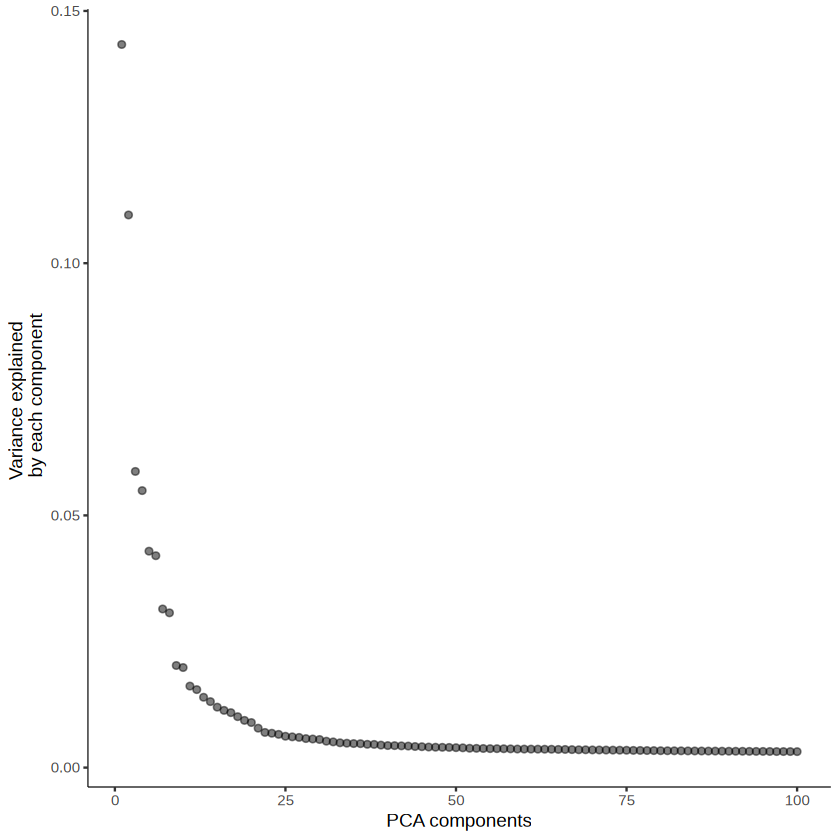

In [4]:
cds <- preprocess_cds(cds, num_dim = 100)

plot_pc_variance_explained(cds)

## Subset on KO

In [28]:
ko_cds <-
  cds %>% 
  colData() %>% 
  as_tibble() %>% 
  pull(mixscape_class) %>% 
  str_detect("KO") %>% 
  cds[, .]

In [29]:
ko_cds <- reduce_dimension(
  ko_cds, 
  reduction_method = "UMAP",
  preprocess_method = "PCA",
  max_components = 25, 
  cores = 60
)

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'



No trajectory to plot. Has learn_graph() been called yet?



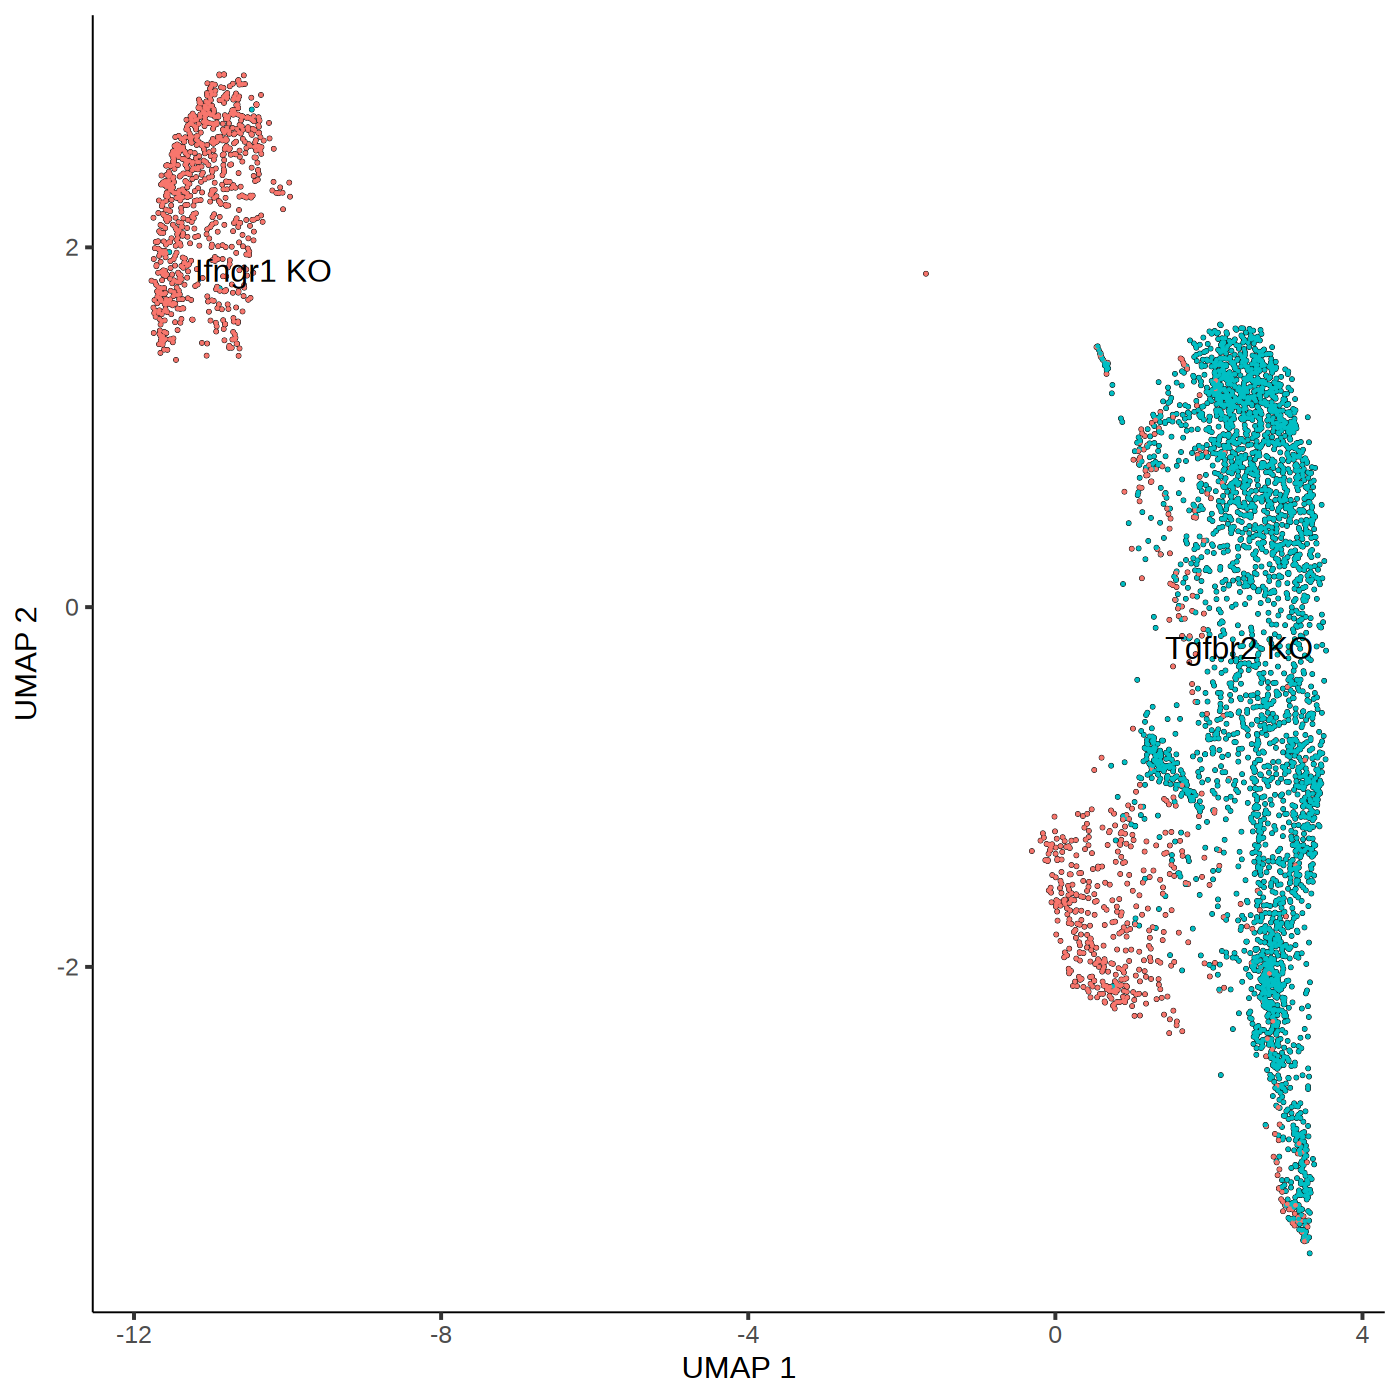

In [30]:

p <- plot_cells(ko_cds, color_cells_by = "mixscape_class")

p$layers[[3]]$aes_params$size <- 4

p

In [34]:
rowData(ko_cds)$gene_short_name <- ko_cds |> rowData() |> rownames()

rowData(ko_cds)$is_rb <-
    ko_cds |>
    rowData() |>
    rownames() |> 
    str_detect("Rps|Rpl")

ko_cds <- ko_cds[!rowData(ko_cds)$is_rb, ]

In [ ]:
gene_fits <- fit_models(ko_cds, model_formula_str = "~mixscape_class", cores = 60)

fit_coefs <- gene_fits %>% 
  coefficient_table()

results <- 
  fit_coefs %>% 
  filter(str_detect(term, "mixscape_class")) %>% 
  filter(q_value <= 0.05) %>% 
  select(gene_short_name, term, q_value, estimate)

Warning message:
“ggrepel: 1164 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


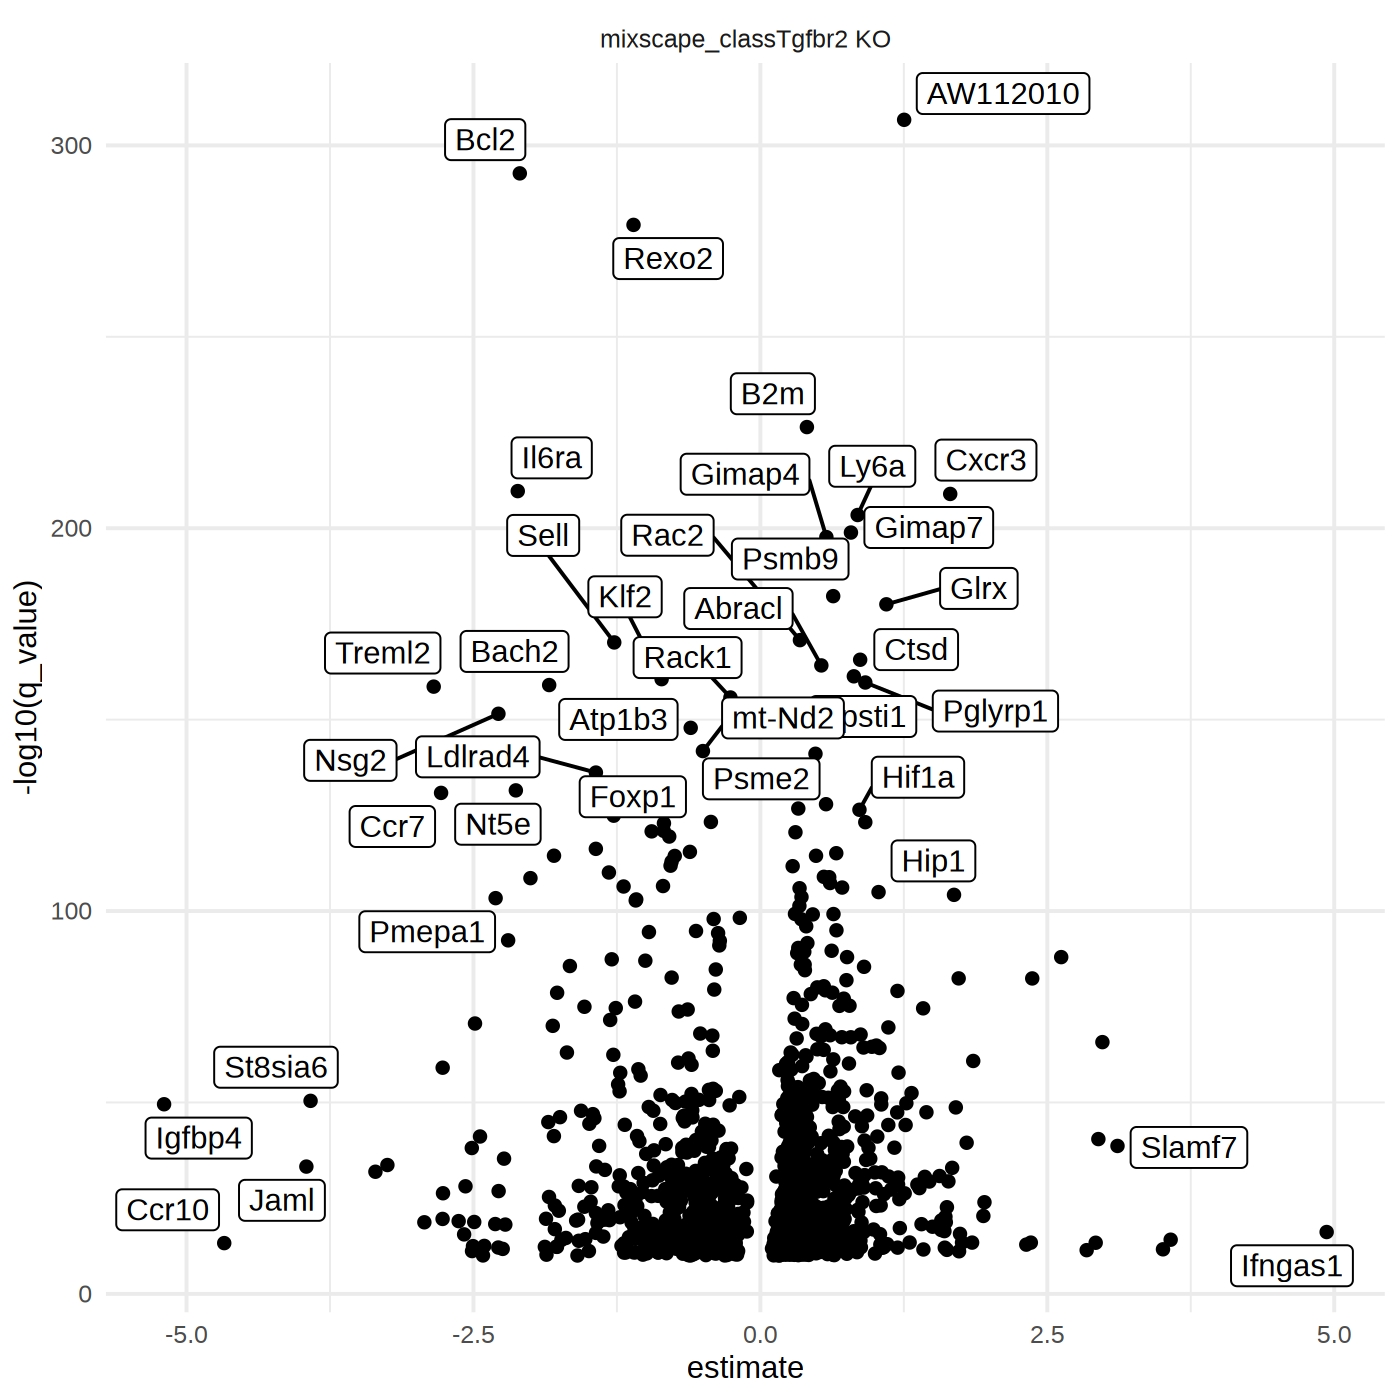

In [38]:
results %>% 
    filter(-log10(q_value) > 10) |>
    ggplot(aes(x = estimate, y = -log10(q_value))) +
    geom_point() +
    facet_wrap(~term) +
    ggrepel::geom_label_repel(aes(label = gene_short_name), max.overlaps = 15) +
    theme_minimal()

## Psuedobulking